## **Anomaly Detection with Autoencoders**

In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [2]:
#For google colab
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
#Your path
%cd '/content/drive/MyDrive/project/'

Mounted at /content/drive
/content/drive/MyDrive/project


In [3]:
#Import and concat all files
path = r'S5_database/A1Benchmark' #set the path accordingly
all_files=glob.glob(path+"/*.csv")

In [4]:
preprocessed_dfs = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['value'] = df['value'].replace(0, np.nan)
    df = df.dropna(subset=['value'])

    # Normalize the 'value' column
    normalized_values = preprocessing.normalize([df['value'].to_numpy()])[0]
    df['value'] = normalized_values

    preprocessed_dfs.append(df)

concatenated_df = pd.concat(preprocessed_dfs, axis=0, ignore_index=True)

In [5]:
concatenated_df

,timestamp,value,is_anomaly
0,1,7.585836e-07,0
1,2,1.444452e-03,0
2,3,3.023026e-02,0
3,4,3.017998e-02,0
4,5,2.915941e-02,0
...,...,...,...
92673,1435,1.204849e-02,0
92674,1436,1.272917e-02,0
92675,1437,1.298406e-02,0
92676,1438,1.432975e-02,0


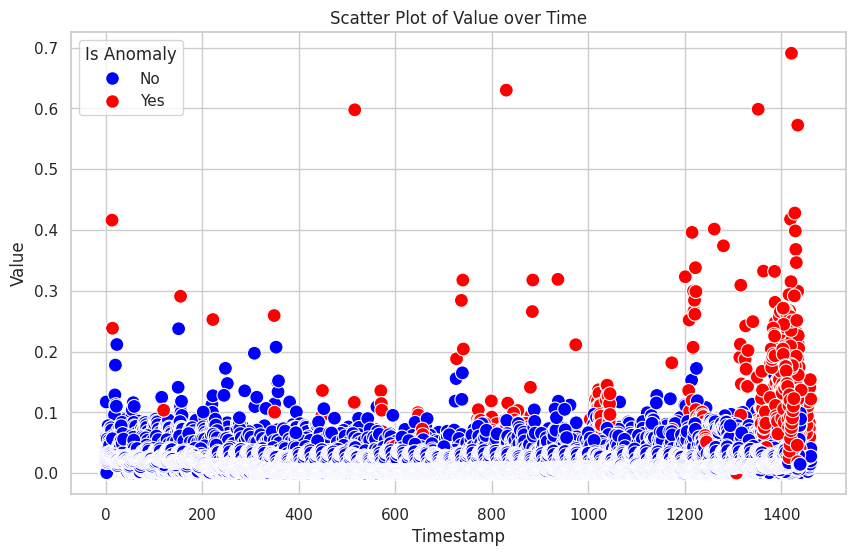

In [6]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a scatter plot with seaborn
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x='timestamp', y='value', hue='is_anomaly', data=concatenated_df, palette={0: 'blue', 1: 'red'}, s=100)

# Create custom legend handles
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)
]

# Add legend with custom handles
plt.legend(handles=legend_handles, title='Is Anomaly', labels=['No', 'Yes'], loc='upper left')


# Set plot title and labels
plt.title('Scatter Plot of Value over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')

# Show the plot
plt.show()

In [7]:
#concatenated_df.to_csv('final_dataset.csv', index=False)

[[27220    73]
 [  261   250]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27293
           1       0.77      0.49      0.60       511

    accuracy                           0.99     27804
   macro avg       0.88      0.74      0.80     27804
weighted avg       0.99      0.99      0.99     27804



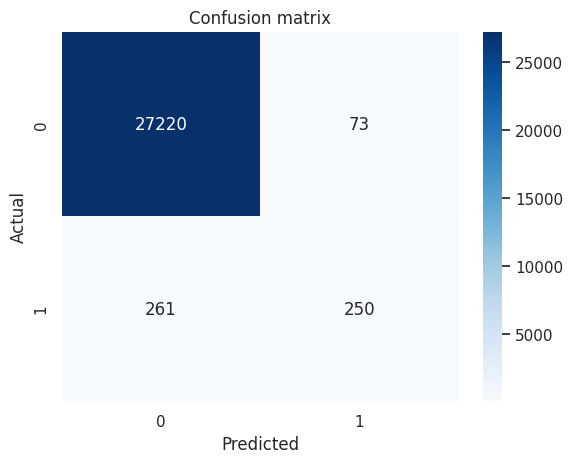

In [8]:
# first try random forest and see how the model performs

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(concatenated_df.drop('is_anomaly', axis=1), concatenated_df['is_anomaly'], test_size=0.3, random_state=42)

# Creating a Random Forest classifier object
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# Fitting the Random Forest classifier to the training data
rfc.fit(X_train, y_train)

# Making predictions on the testing data
y_pred = rfc.predict(X_test)

# Printing the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

**Tried Keras**

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [10]:
# Define the autoencoder architecture
def create_autoencoder(input_dim):
    encoder = models.Sequential([
        layers.InputLayer(input_shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu')
    ])

    decoder = models.Sequential([
        layers.InputLayer(input_shape=(8,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(input_dim, activation='linear')
    ])

    autoencoder = models.Sequential([encoder, decoder])

    return autoencoder

In [12]:
# Assuming your dataset is in a Pandas DataFrame
# X_train is the feature data, and y_train is the label data
X_train = concatenated_df[['timestamp', 'value']]
y_train = concatenated_df['is_anomaly']

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()


# Create the autoencoder
input_dim = X_train.shape[1]
autoencoder = create_autoencoder(input_dim)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [13]:
# Train the autoencoder
epoch_losses = []
for epoch in range(100):
    history = autoencoder.fit(X_train, X_train, epochs=1, batch_size=64, shuffle=True, validation_split=0.2)
    epoch_losses.append(history.history['loss'][0])

# Extract the encoder for feature representation
encoder = autoencoder.layers[0]

# Now you can use the encoder for classification
classifier = models.Sequential([
    encoder,
    layers.Dense(1, activation='sigmoid')
])

# Compile the classifier
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the classifier
classifier.fit(X_train, y_train, epochs=10, batch_size=64, shuffle=True, validation_split=0.2)


1159/1159 [==============================] - 5s 4ms/step - loss: 4.9220e-05 - val_loss: 2.1770e-06
Epoch 1/10
1159/1159 [==============================] - 9s 6ms/step - loss: 0.1221 - accuracy: 0.9627 - val_loss: 0.0393 - val_accuracy: 0.9927
Epoch 2/10
1159/1159 [==============================] - 5s 4ms/step - loss: 0.0677 - accuracy: 0.9832 - val_loss: 0.0419 - val_accuracy: 0.9925
Epoch 3/10
1159/1159 [==============================] - 5s 5ms/step - loss: 0.0651 - accuracy: 0.9832 - val_loss: 0.0443 - val_accuracy: 0.9908
Epoch 4/10
1159/1159 [==============================] - 6s 6ms/step - loss: 0.0636 - accuracy: 0.9835 - val_loss: 0.0385 - val_accuracy: 0.9917
Epoch 5/10
1159/1159 [==============================] - 5s 4ms/step - loss: 0.0625 - accuracy: 0.9834 - val_loss: 0.0396 - val_accuracy: 0.9928
Epoch 6/10
1159/1159 [==============================] - 6s 5ms/step - loss: 0.0614 - accuracy: 0.9837 - val_loss: 0.0376 - val_accuracy: 0.9928
Epoch 7/10
1159/1159 [===============

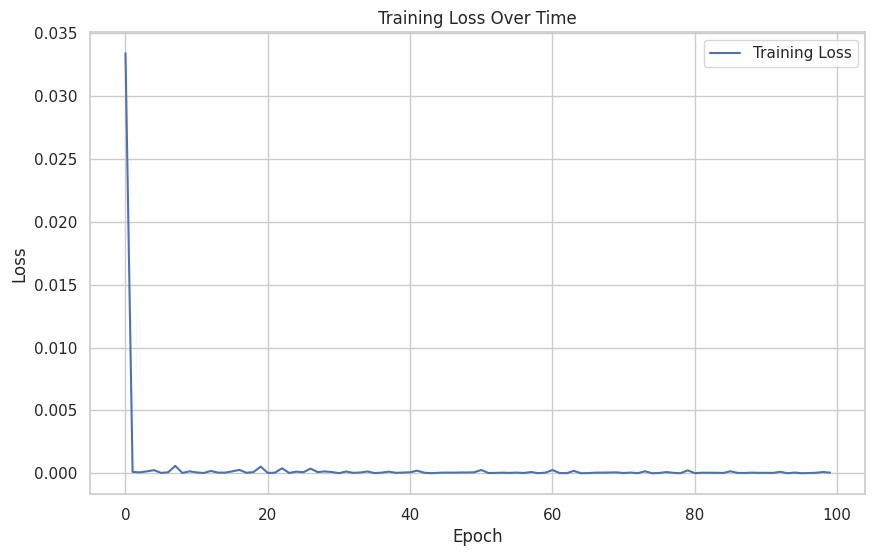

In [14]:
# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

**Anomaly Detection with Autoencoders with Pytorch**

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [41]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [42]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(concatenated_df.drop('is_anomaly', axis=1), concatenated_df['is_anomaly'], test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = scaler.fit_transform(X_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training
dataset = TensorDataset(X_train, X_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)



In [43]:
# Instantiate the autoencoder
input_dim = X_train.shape[1] # size [64874, 2]
autoencoder = Autoencoder(input_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [44]:
num_epochs = 100
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in dataloader:
        inputs, _ = batch
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_loss = total_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/100, Loss: 0.1529
Epoch 2/100, Loss: 0.0003
Epoch 3/100, Loss: 0.0001
Epoch 4/100, Loss: 0.0000
Epoch 5/100, Loss: 0.0000
Epoch 6/100, Loss: 0.0000
Epoch 7/100, Loss: 0.0001
Epoch 8/100, Loss: 0.0000
Epoch 9/100, Loss: 0.0000
Epoch 10/100, Loss: 0.0002
Epoch 11/100, Loss: 0.0000
Epoch 12/100, Loss: 0.0000
Epoch 13/100, Loss: 0.0000
Epoch 14/100, Loss: 0.0001
Epoch 15/100, Loss: 0.0000
Epoch 16/100, Loss: 0.0000
Epoch 17/100, Loss: 0.0000
Epoch 18/100, Loss: 0.0001
Epoch 19/100, Loss: 0.0000
Epoch 20/100, Loss: 0.0000
Epoch 21/100, Loss: 0.0000
Epoch 22/100, Loss: 0.0000
Epoch 23/100, Loss: 0.0001
Epoch 24/100, Loss: 0.0000
Epoch 25/100, Loss: 0.0002
Epoch 26/100, Loss: 0.0000
Epoch 27/100, Loss: 0.0000
Epoch 28/100, Loss: 0.0000
Epoch 29/100, Loss: 0.0001
Epoch 30/100, Loss: 0.0000
Epoch 31/100, Loss: 0.0000
Epoch 32/100, Loss: 0.0000
Epoch 33/100, Loss: 0.0001
Epoch 34/100, Loss: 0.0000
Epoch 35/100, Loss: 0.0000
Epoch 36/100, Loss: 0.0000
Epoch 37/100, Loss: 0.0001
Epoch 38/1

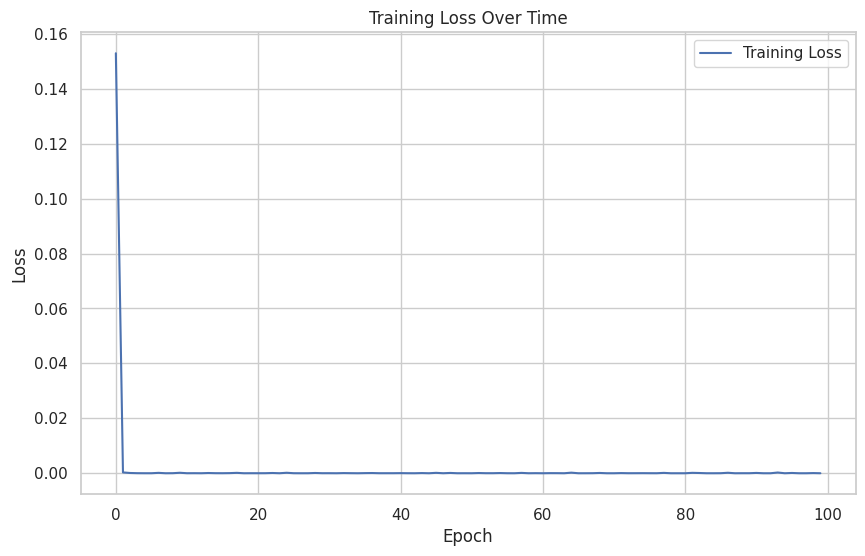

In [45]:
# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [46]:
# Extract the encoder for feature representation
encoder = autoencoder.encoder

class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(4, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.sigmoid(self.fc(x))
        return x

# Instantiate the classifier
classifier = Classifier(encoder)

# Define the loss function and optimizer for the classifier
criterion_classifier = nn.BCELoss()
optimizer_classifier = optim.Adam(classifier.parameters(), lr=0.001)

# Convert labels to PyTorch tensor
y_train = y_train.view(-1, 1)

# Training loop for the classifier
num_classifier_epochs = 10

for epoch in range(num_classifier_epochs):
    optimizer_classifier.zero_grad()
    outputs = classifier(X_train)
    loss = criterion_classifier(outputs, y_train)
    loss.backward()
    optimizer_classifier.step()

    print(f"Classifier Epoch {epoch+1}/{num_classifier_epochs}, Loss: {loss.item():.4f}")

Classifier Epoch 1/10, Loss: 0.5861
Classifier Epoch 2/10, Loss: 0.5767
Classifier Epoch 3/10, Loss: 0.5673
Classifier Epoch 4/10, Loss: 0.5581
Classifier Epoch 5/10, Loss: 0.5490
Classifier Epoch 6/10, Loss: 0.5400
Classifier Epoch 7/10, Loss: 0.5312
Classifier Epoch 8/10, Loss: 0.5225
Classifier Epoch 9/10, Loss: 0.5139
Classifier Epoch 10/10, Loss: 0.5055


In [47]:
# Check if GPU is available and use it, otherwise use CPU
device = torch.device("cpu")
autoencoder.to(device)
classifier.to(device)

Classifier(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [50]:
# Create DataLoader for the test set
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set the model to evaluation mode
autoencoder.eval()
classifier.eval()

# Evaluation loop
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Pass inputs through the autoencoder
        encoded_features = autoencoder.forward(inputs)

        # Pass encoded features through the classifier
        outputs = classifier(encoded_features)

        # Assuming binary classification
        predicted = torch.argmax(outputs, 1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')

Accuracy on Test Set: 98.16%
